In [2]:
import torch
import torchvision.models as models
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F
import cv2 as cv
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import utils
from torch.optim import Adam
import algos
import importlib
importlib.reload(algos)
import copy

In [3]:
vgg = models.vgg16(weights="DEFAULT")
vgg.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vgg.to(device)

with open('imagenet-simple-labels.json', 'r') as f:
    class_names = json.load(f)


pretransform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = transforms.Normalize(mean=mean, std=std) 

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
def clip_eps(tensor,eps):
    return torch.clamp(tensor,min=-eps,max=eps)

In [5]:
def pgd(image,target,model,loss_fn,steps,alpha,eps=0.01):
    "Implementation of projected gradient descent to create adversarial images"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    target = torch.tensor([target],device=device )
    x = pretransform(image)
    x = x.unsqueeze(0)
    x = x.to(device)
    x_adv = copy.deepcopy(x)
    eta = torch.zeros_like(x_adv).to(device)
    for i in range(steps):
        x_adv = algos.fgsm(x_adv,model,loss_fn,label=target,targeted=True,eps=eps)
        eta = x_adv-x
        eta = clip_eps(eta,eps)
        x_adv = x+eta
    return x_adv

Predicted class: magpie
Probability: 0.6953


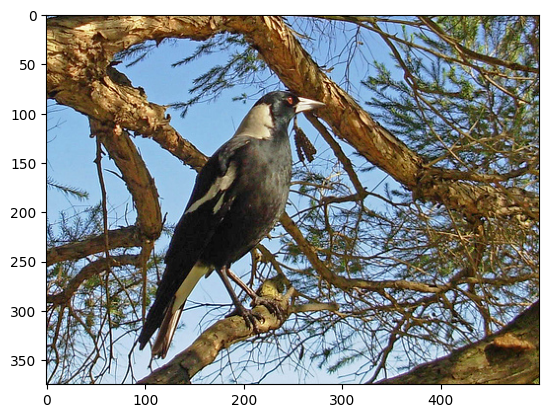

In [20]:
loss_fn  = torch.nn.CrossEntropyLoss()
utils.predict(vgg,transform,"testImages/bird.JPEG",class_names)
plt.figure()
img = Image.open("testImages/bird.JPEG").convert("RGB")
plt.imshow(img)

In [24]:
adv_x = pgd(img,105,vgg,loss_fn,500,0.001)

tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([105], device='cuda:0')
tensor([

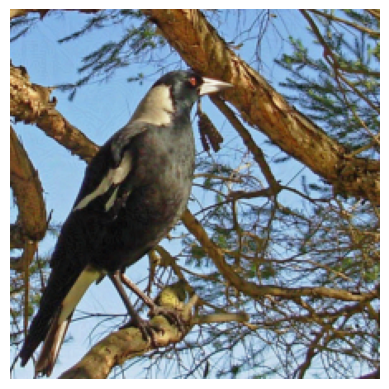

In [25]:
pertubed_img = adv_x[0]
pertubed_img =  pertubed_img.detach().to("cpu")
utils.show_img(pertubed_img)

In [26]:
input_img = normalize_transform(pertubed_img)
utils.predict(vgg,transform,input_img,class_names,transformed=True)

Predicted class: koala
Probability: 0.9953


105

# Adversarial Attack Implementation: FGSM and PGD with VGG16

Here, we use two different algorithms, FGSM(Fast Gradient Sign Method) and PGD(Projected Gradient Descent) to create images, that are identical to the input for the human eye but, fools the image classification models into misclassifying the image as something else.
These algorithms work on almost all image classification model, but in my project I have used the VGG16 classifier as an example.
The attacks can be targeted(Misclassify the input image to a specified target label) or untargeted ( Misclassify the input image to any label other than its original label). The algorithm for both attacks remains the same, but the definition of the loss function changes based on the attack.

## FGSM(Fast Gradient Sign Method)

This method was introduced by Goodfellow et.al. This algorithm generates the adversarial image in a single step making it highly efficient and is used extensively to create adversarial examples to train robust classifiers.
This algorithm works by calculating the cross-entropy loss of the image classifier and using gradient descent to modify the image to increase the loss further (in case of untargeted attacks). In targeted attacks, this algorithm aims to improve the probability of the target variable.
Each pixel of the image is only modified by a small value($\epsilon$) so the changes are imperceptible to the human eye.


<table>
  <tr>
    <td align="center">
      <img src="testImages/dog_fgsm.png" alt="Treeing Walker Coonhound" width="300"><br>
      Input image(Treeing Walker Coonhound)
    </td>
    <td align="center">
      <img src="testImages/dog_fgsm_pet.png" alt="Chihuahua" width="300"><br>
      Generated FGSM petrubation
    </td>
     <td align="center">
      <img src="testImages/dog_fgsm.png" alt="Chihuahua" width="300"><br>
      Image with petrubation applied(classified as Chihuahua)
    </td>
    <td align="center">
      <img src="testImages/Chihuahua.jpg" alt="Chihuahua" width="300"><br>
      Actual image of a Chihuahua
    </td>
  </tr>
  <tr>
     <td align="center">
      <img src="testImages/bird.JPEG" alt="Treeing Walker Coonhound" width="300"><br>
      Input image(Magpi)
    </td>
    <td align="center">
      <img src="testImages/bird_fgsm_pet.png" alt="Chihuahua" width="300"><br>
      Generated FGSM petrubation
    </td>
     <td align="center">
      <img src="testImages/bird_fgsm.png" alt="Chihuahua" width="300"><br>
      Image with petrubation applied(classified as Crayfish)
    </td>
    <td align="center">
      <img src="testImages/creyfish.jpg" alt="Chihuahua" width="300"><br>
      Actual image of a Crayfish
    </td>
  </tr>
</table>


## PGF(Projected Gradient Descent)

This algorithm was introduced by Simon Geisler et.al and is built of top of FGSM. It is an iterative algorithm, that tries to find the smallest change to bring about misclassification.
This method produces better quality images and has a higher success rate for targeted misclassification when compared to FGSM,but it has higher compute requirements when compared to FGMS due to its iterative nature.

### The images generated below are generated using PGD, with the target set. Hyperparameters: 500 epochs and learning rate: 0.001

<table>
  <tr>
    <td align="center">
      <img src="testImages/dog_fgsm.png" alt="Treeing Walker Coonhound" width="300"><br>
      Input image(Treeing Walker Coonhound)
    </td>
     <td align="center">
      <img src="testImages/dog_pgd_wippet.png" alt="Chihuahua" width="300"><br>
      Image with petrubation applied(classified as wippet,target was wippet)
    </td>
    <td align="center">
      <img src="testImages/wippet.jpg" alt="Chihuahua" width="300"><br>
      Actual image of a wippet
    </td>
  </tr>
  <tr>
     <td align="center">
      <img src="testImages/bird.JPEG" alt="Treeing Walker Coonhound" width="300"><br>
      Input image(Magpi)
    </td>
     <td align="center">
      <img src="testImages/bird_pgd_koala.png" alt="Chihuahua" width="300"><br>
      Image with petrubation applied(classified as koala, target was koala)
    </td>
    <td align="center">
      <img src="testImages/koala.jpg" alt="Chihuahua" width="300"><br>
      Actual image of a koala
    </td>
  </tr>
</table>